# 章節 13：模擬

## 13.5 快取聯合分佈（Caching the joint distribution）

這邊說上一小節的 Cache 類別怎麼做的。

In [70]:
import math
import thinkbayes as tb
import numpy as np
import matplotlib.pyplot as plt


def Diameter(volume, factor=4*math.pi/3):
    return 2*(volume/factor)**(1/3)


# 桶子是均勻分佈在對數空間
def CmToBucket(x, factor=10):
    # 用 factor=10 產生合適的桶子數量
    # 例如 1 公分對應到桶子 0，10公分對應到桶子 23
    return factor * math.log(x)


class Cache(object):
    
    def __init__(self):
        
        # joint 是一個紀錄 年齡-大小 配對頻率的的聯合(joint) Pmf
        # 聯合 Pmf 為了近似 年齡-大小 的分佈
        self.joint = tb.Joint()
        
    # 每次模擬時， ExtendSequence 呼叫 Cache.Add 方法
    def Add(self, age, seq, factor=2):
        # age：腫瘤的年齡
        # seq：到目前為止的腫瘤體積變化序列
        
        # 最近一次的腫瘤體積
        final = seq[-1]
        
        # 再加入到聯合分佈之前，將體積轉成直徑
        # 將體積轉換成直徑（公分）
        cm = Diameter(final)
        
        # CmToBucket 方法將公分轉成離散的桶子編號（bucket number）
        # 離散化讓 年齡-大小 的頻率比較可以累積
        bucket = round(CmToBucket(cm, factor=factor)) 
        
        self.joint.Incr((age, bucket))


將上一小節的程式碼放到下方，準備模擬腫瘤成長過程。

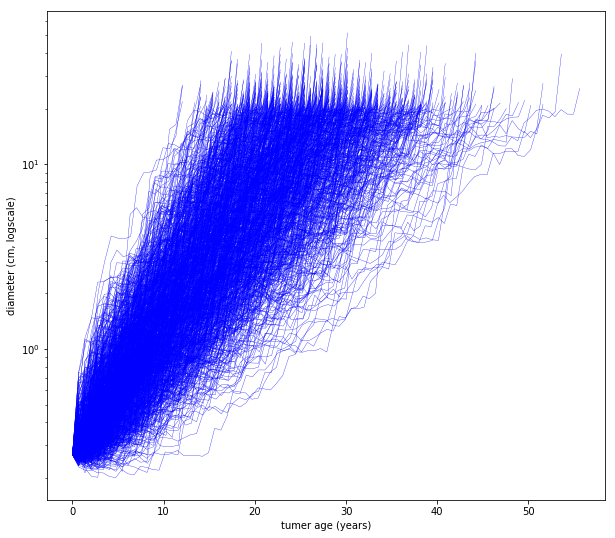

In [76]:
cache = Cache()


# 計算在時間區間結束後，腫瘤的體積
def ExtendSequence(age, seq, rdt, interval):
    # age：在時間區間結束後，腫瘤的年齡
    # seq：是一個 tuple 包含到目前為止的體積
    # rdt：在這個時間區間的成長率（每年翻倍的比率 doubling per year）
    # interval：經過的時間區間（年）
    
    initial = seq[-1]
    doublings = rdt * interval
    final = initial * 2**doublings
    new_seq = seq + (final,)
    
    
    # Cache.Add 紀錄每個腫瘤在時間區間結束時的的年齡跟大小，下一小節會解釋 Cache 的機制
    # 在此先註解掉
    cache.Add(age, new_seq, factor=10)

    # final：時間區間結束後腫瘤的體積
    # new_seq：一個新的 tuple 除了舊的體積外還包含最後的體積 final
    return final, new_seq


# 將直徑轉（公分）成體積（立方公分）。這邊假設腫瘤是球體。
def Volume(diameter, factor=4*math.pi/3):
    # 球體體積公式
    return factor * (diameter/2.0)**3


def Diameter(volume, factor=4*math.pi/3):
    return 2*(volume/factor)**(1/3)



def MakeSequence(rdt_seq, v0=0.01, interval=0.67, vmax=Volume(20.0)):
    # rdt_seq：一個從生長率的 CDF 取樣的迭代器
    # v0：是初始體積（立方公分）
    # interval：時間區間（年）
    # vmax: 最大的直徑 20 公分
    
    seq = v0,
    age = 0
    for rdt in rdt_seq:
        age += interval
        final, seq = ExtendSequence(age, seq, rdt, interval)
        
        if final > vmax:
            break
        
    return seq




def make_exp_pmf(low, high, lam, n=1000, frac=1.0):
    pmf = tb.Pmf()
    for i in np.linspace(low, high, n):
        pmf.Set(i, tb.EvalExponentialPdf(i, lam))
    
    pmf.Normalize(fraction=frac)
    return pmf


def make_rdt_seq(pmf_lower, pmf_higher):
    cdf_lower = pmf_lower.MakeCdf()
    cdf_higher = pmf_higher.MakeCdf()
    
    while True:
        if np.random.random() <= 0.35:
            yield cdf_lower.Sample(1)[0]
        else:
            yield cdf_higher.Sample(1)[0]
            
    

lam_lower = -5    
pmf_lower = make_exp_pmf(-2, 0, lam_lower, n=2000)

lam_higher = 0.79
pmf_higher = make_exp_pmf(0, 7, lam_higher, n=7000)

rdt_seq = make_rdt_seq(pmf_lower, pmf_higher)

plt.figure(figsize=(10,9))
for i in range(1000):
    # 將體積轉乘半徑的比例
    y = [Diameter(volume) for volume in MakeSequence(rdt_seq)]
    x = np.linspace(0, len(y)*0.67, len(y))
    plt.yscale("log")
    plt.plot(x, y, c='b', linewidth=0.3)
    
plt.xlabel("tumer age (years)")
plt.ylabel("diameter (cm, logscale)")
plt.show()

下方畫出聯合分佈圖。

(56, 82)


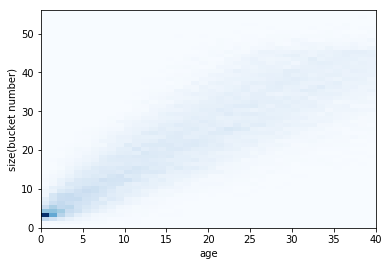

In [101]:
xy, z = zip(*cache.joint.Items())
age, size = zip(*xy)

u_age, u_size = np.unique(age), np.unique(size)

mz = np.zeros((u_size.size, u_age.size))
print(mz.shape)

for i, vy in enumerate(sorted(u_size)):
    for j, vx in enumerate(sorted(u_age)):
        mz[i, j] = cache.joint.Prob((vx, vy))

plt.pcolor(mz, cmap='Blues')
plt.axis(xmax=40)
plt.xlabel("age")
plt.ylabel("size(bucket number)")
plt.show()

跑完模擬後，我們可以畫出聯合分佈的偽彩色圖（psudocolor plot），其中每一格代表有多少腫瘤在對應的 大小-年齡 被觀察到。上圖顯示的聯合分佈偽彩色圖是跑 1000 次模擬的結果。